In [1]:
from matplotlib import pyplot as plt
from Bio import Phylo
import pandas as pd
import numpy as np
from copy import deepcopy
from io import StringIO
import matplotlib as mpl
from scripts.lib.plotting import load_style
import sqlite3
from itertools import product
from sklearn.manifold import MDS
from collections import defaultdict


loaded_style = load_style('paper')
savefig = loaded_style['savefig']
fullwidth = loaded_style['fullwidth']
halfwidth = loaded_style['halfwidth']

def annotate_clade_with_plotting_metadata(clade, left=0, bottom=0):
    branch_length = clade.branch_length
    if not branch_length:
        branch_length = 0
    clade.left = left
    clade.right = left + branch_length
    if clade.is_terminal():
        clade.y = bottom
        return 0, clade.y  # total_offset, root_pos
    else:
        roots = []
        total_offset = 0
        for c in clade.clades:
            offset, root_pos = annotate_clade_with_plotting_metadata(
                    c, left=clade.right, bottom=bottom + total_offset)
            roots.append(root_pos)
            total_offset += offset + 1
        clade.y = (min(roots) + max(roots)) / 2.0
        return total_offset - 1, clade.y

def plot_clade(clade, ax,
               tax_plotter=lambda c, ax: (),
               node_plotter=lambda c, ax: (),
               lw=1):
    ax.hlines(clade.y, clade.left, clade.right, lw=lw)
    children_ys = [plot_clade(c, ax,
                              tax_plotter=tax_plotter,
                              node_plotter=node_plotter,
                             )
                   for c in clade.clades]
    if children_ys:
        ymin = min(children_ys)
        ymax = max(children_ys)
        ax.vlines(clade.right, ymin, ymax, lw=lw)
    if clade.is_terminal():
        tax_plotter(clade, ax)
    node_plotter(clade, ax)
    return clade.y

def plot_tree(tree, ax, **kwargs):
    tree = deepcopy(tree)
    clade = getattr(tree, 'clade', tree)
    annotate_clade_with_plotting_metadata(clade)
    plot_clade(clade, ax, **kwargs)
    return tree
    
def fold_by_group(clade, key):
    if clade.is_terminal():
        clade.group = key(clade)
        clade.minbranch = 0
        clade.maxbranch = 0
        clade.count = 1
        return clade.group, clade.branch_length, clade.branch_length, 1
    else:
        child_group, child_minbranch, child_maxbranch, child_count = \
                zip(*[fold_by_group(c, key) for c in clade.clades])
        unique_groups = set(child_group)
        if (None in unique_groups) or len(unique_groups) > 1:
            # Children are not of one group
            # don't collapse anything and pass on null values
            return None, 0, 0, None
        else:
            # It IS a unique group
            # so drop the children
            clade.count = sum(child_count)
            clade.clades = []
            # and pass on the group and the branch lengths
            clade.group = unique_groups.pop()
            assert not unique_groups, "After popping, I expect unique_groups to be an empty set."
            clade.minbranch = min(child_minbranch)
            clade.maxbranch = max(child_maxbranch)
            return (clade.group,
                    clade.minbranch + clade.branch_length,
                    clade.maxbranch + clade.branch_length,
                    clade.count)

Tree(rooted=False, weight=1.0)

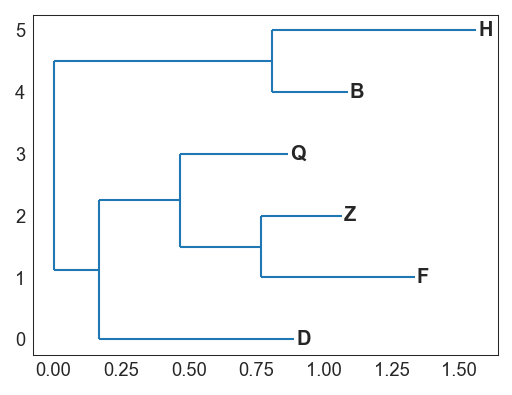

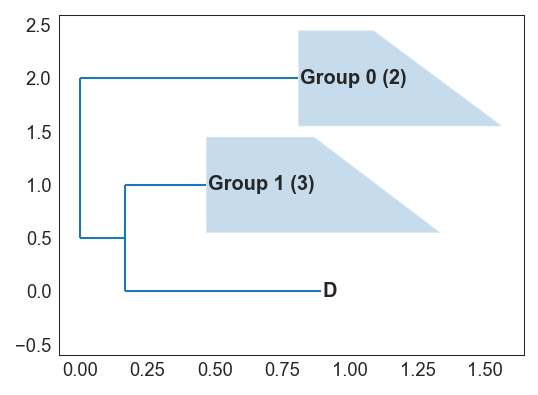

In [2]:
def _tax_plotter(clade, ax):
    if clade.name:
        label = clade.name
    else:
        label = '{} ({})'.format(clade.group, clade.count)
    if hasattr(clade, 'minbranch'):
        x = [clade.right,
             clade.right + clade.minbranch,
             clade.right + clade.maxbranch,
             clade.right
            ]
        y = [clade.y + 0.45] * 2 + [clade.y - 0.45] * 2
        ax.add_patch(plt.Polygon(xy=list(zip(x, y)), alpha=0.25))
    ax.annotate(label, xy=(clade.right + 0.0075, clade.y), ha='left', va='center', weight='bold')

test_tree_string = '((D:0.723274,((F:0.567784,Z:0.3):0.3, Q:0.4):0.3)1.000000:0.167192,(B:0.279326,H:0.756049)1.000000:0.807788);'
tree = Phylo.read(StringIO(test_tree_string), 'newick')
fig, ax = plt.subplots()
plot_tree(tree, ax, tax_plotter=_tax_plotter)


fold_by_group(tree.clade, lambda c: {'H': 'Group 0', 'B': 'Group 0', 'Q': 'Group 1', 'Z': 'Group 1', 'F': 'Group 1', 'D': 'Group 0'}[c.name])
fig, ax = plt.subplots()
plot_tree(tree, ax, tax_plotter=_tax_plotter)

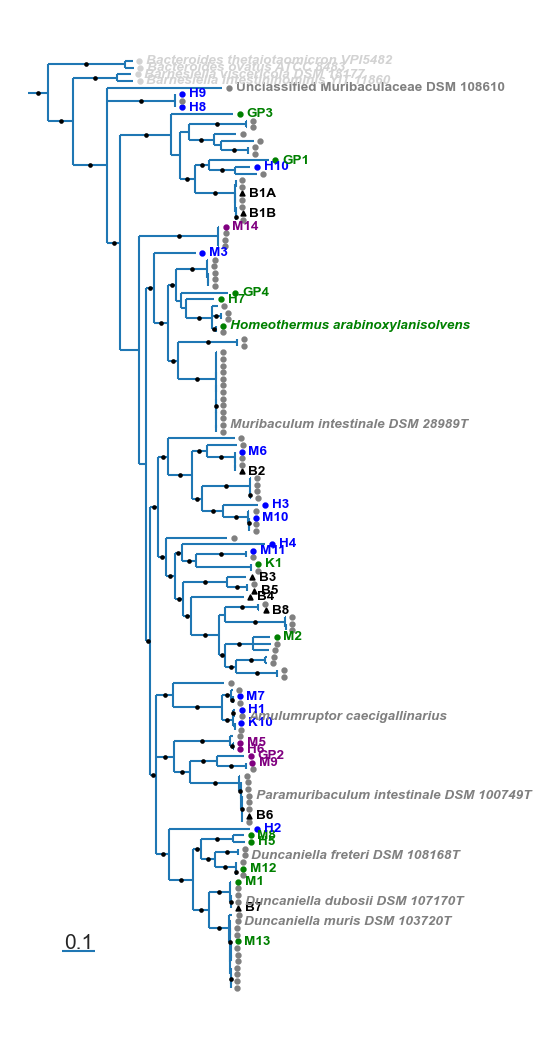

In [7]:
plt.rcParams['svg.fonttype'] = 'none'

color_map = { 'starch': 'blue'
            , 'host': 'purple'
            , 'plant': 'green'
            }

italic_list = [ 'Barnesiella_viscericola_DSM_18177'
              , 'Barnesiella_intestinihominis_YIT_11860'
              , 'Bacteroides_ovatus_ATCC_8483'
              , 'Bacteroides_thetaiotaomicron_VPI5482'
              , 'Porphyromonas_gingivalis_ATCC_33277'
              , 'Homeothermus_arabinoxylanisolvens'
              , 'Muribaculum_intestinale_DSM_28989T'
              , 'Duncaniella_muris_DSM_103720T'
              , 'Duncaniella_freteri_DSM_108168T'
              , 'Duncaniella_dubosii_DSM_107170T'
              , 'Paramuribaculum_intestinale_DSM_100749T'
              , 'Amulumruptor_caecigallinarius'
              ]

con = sqlite3.connect('data/core.muri2.2.denorm.db')

mag = (
    pd.read_sql(
    """
SELECT *
FROM genome
JOIN checkm USING (genome_id)
JOIN genome_group USING (genome_id)
WHERE genome_group_id = 'muri2'
    """,
    index_col='genome_id',
    con=con,
    )
)

rename_taxon = {
#                  'Barnesiella_viscericola_DSM_18177': 'Bv'
#                , 'Bacteroides_ovatus_ATCC_8483': 'Bo'
#                , 'Bacteroides_thetaiotaomicron_VPI5482': 'Bt'
#                , 'Porphyromonas_gingivalis_ATCC_33277': 'Pg'
#                , 'Homeothermus_arabinoxylanisolvens': 'Ha'
#                , 'Muribaculum_intestinale_DSM_28989T': 'Mi'
#                , 'Duncaniella_muris_DSM_103720T': 'Dm'
#                , 'Duncaniella_freteri_DSM_108168T': 'Df'
#                , 'Duncaniella_dubosii_DSM_107170T': 'Dd'
#                , 'Paramuribaculum_intestinale_DSM_100749T': 'Pi'
#                , 'Amulumruptor_caecigallinarius': 'Ac'
#                , 'Barnesiella_intestinihominis_YIT_11860': 'Bi'
               }

for _name, x in mag.iterrows():
    if _name.startswith('GCA_'):
        rename_taxon[_name] = ''  # mag.loc[_name].genbank_accession
    else:
        rename_taxon[_name] = _name.replace('_', ' ')


colormap = color_map = { 'ormerod-starch': 'blue'
                       , 'ormerod-host': 'purple'
                       , 'ormerod-plant': 'green'
                       , 'public': 'grey'
                       , 'here': 'black'
                       , 'outgroup': 'lightgrey'
                       }

marker_map = {'ormerod-plant': 'o', 'ormerod-host': 'o', 'ormerod-starch': 'o', 'public': 'o', 'here': '^', 'outgroup': 'o'}

def _tax_plotter(clade, ax):
    if clade.name in rename_taxon:
        # Check if there's a renaming for a given clade.
        label = rename_taxon[clade.name]
    else:
        label = clade.name
        
#     if mag.subgroup[clade.name] == 'here':
#         label = label + '*'
        
    if clade.name in italic_list:
        textstyle = 'italic'
    else:
        textstyle = 'normal'
    
    color = colormap[mag.subgroup[clade.name]]
    ax.scatter(
        [clade.right + 0.02],
        [clade.y],
        color=color,
        marker=marker_map[mag.subgroup[clade.name]],
        s=5,
    )
    ax.annotate(label, xy=(clade.right + 0.04, clade.y),
                ha='left', va='center',
                weight='bold', style=textstyle,
                color=color, fontsize=6.5)
    
def _node_plotter(clade, ax):
    confidence = clade.confidence
    if confidence is None:
        return

    if confidence > 0.95:
        middle = (clade.right + clade.left) / 2
        if clade.is_terminal():
            hpos = middle  # clade.right - 0.013
        else:
            hpos = middle  # clade.right
        color = 'k'
        ax.scatter([hpos], [clade.y], color=color,
                   marker='o', s=5, linewidths=0, edgecolors='k', zorder=10)

    
    
tree = Phylo.read('data/core.a.mags.muri2.g.final.marker_genes.gb.prot.nwk', 'newick')
outgroup = [
              'Porphyromonas_gingivalis_ATCC_33277'
#             , 'Bacteroides_ovatus_ATCC_8483'
#             , 'Bacteroides_thetaiotaomicron_VPI5482'
#            , 'Barnesiella_viscericola_DSM_18177'
           ]
view_outgroup = [
           ]

tree.root_with_outgroup(outgroup)
for t in outgroup:
    if t not in view_outgroup:
        tree.prune(t)
        
tree.clade.branch_length = 0.06
#tree.clade.confidence = None
tree.collapse_all(lambda c: c.confidence is not None and c.confidence < 0.7)
tree.ladderize(reverse=True)

fig, ax = plt.subplots(figsize=(2.5, 9))
tree_annotated = plot_tree(tree, ax,
                           tax_plotter=_tax_plotter,
                           node_plotter=_node_plotter)

#for confidence_label, color in [('> 95%', 'black'),
#                                ('> 90%', 'grey'),
#                                ('> 80%', 'lightgrey'),
#                                ('< 80%', 'white')
#                                ('> 80%', 'white')
#                               ]
#    ax.scatter([], [], color=color, label=confidence_label, s=50, linewidths=2, edgecolors='k')
ax.set_yticks([])
ax.set_xticks([])
#ax.legend(loc='upper left', title='confidence')

scale_xy = (0.1, 5.5)
scale_length = 0.1
_x, _y = scale_xy
ax.hlines([_y], [_x], [_x + scale_length], lw=1)
ax.annotate('{:.1}'.format(scale_length),
            xy=(_x + scale_length / 2, _y + 0.4),
            ha='center', fontsize=10)

# panel = 'A'
# ax.annotate(panel, xy=(0.02, 1.02), xycoords='axes fraction', fontsize=12)


ax.axis('off')
#fig.tight_layout()
 
plt.savefig('fig/phylogenetics_concatenated.svg', dpi=250, bbox_inches='tight')

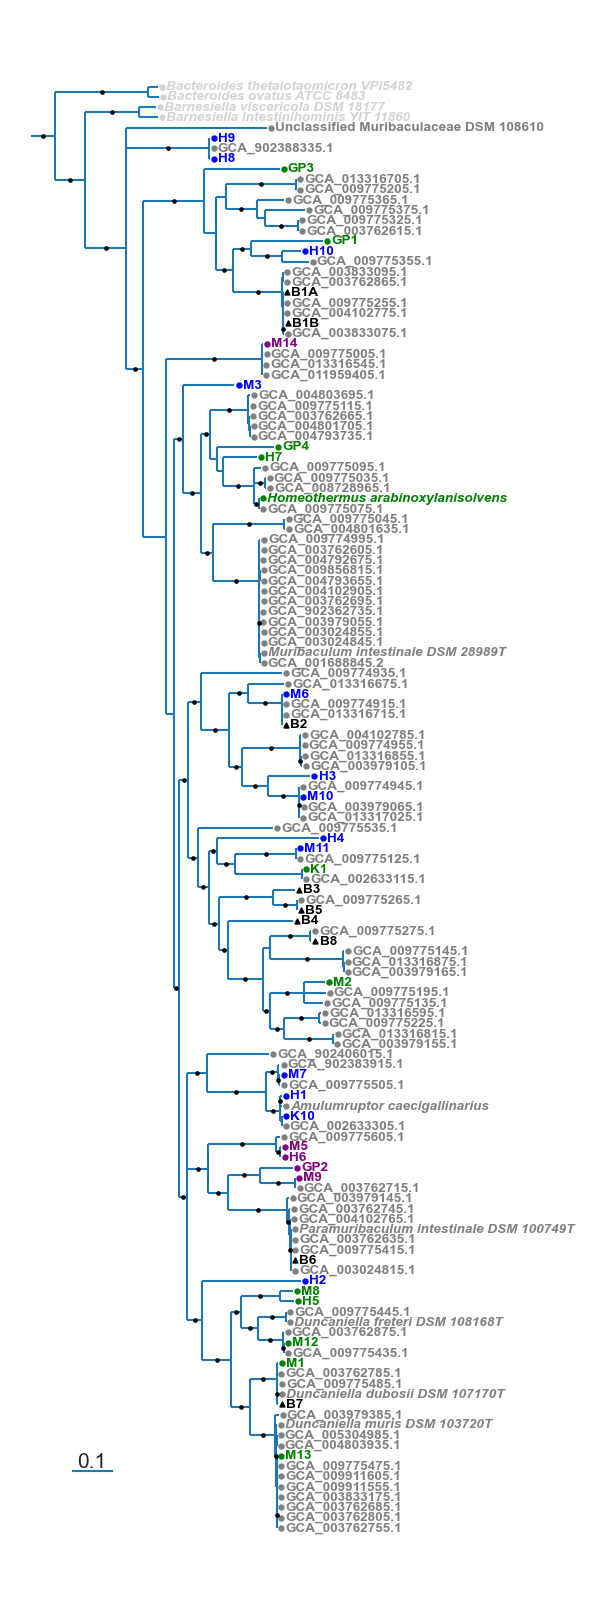

In [10]:
color_map = { 'starch': 'blue'
            , 'host': 'purple'
            , 'plant': 'green'
            }

italic_list = [ 'Barnesiella_viscericola_DSM_18177'
              , 'Barnesiella_intestinihominis_YIT_11860'
              , 'Bacteroides_ovatus_ATCC_8483'
              , 'Bacteroides_thetaiotaomicron_VPI5482'
              , 'Porphyromonas_gingivalis_ATCC_33277'
              , 'Homeothermus_arabinoxylanisolvens'
              , 'Muribaculum_intestinale_DSM_28989T'
              , 'Duncaniella_muris_DSM_103720T'
              , 'Duncaniella_freteri_DSM_108168T'
              , 'Duncaniella_dubosii_DSM_107170T'
              , 'Paramuribaculum_intestinale_DSM_100749T'
              , 'Amulumruptor_caecigallinarius'
              ]

con = sqlite3.connect('data/core.muri2.2.denorm.db')

mag = (
    pd.read_sql(
    """
SELECT *
FROM genome
JOIN checkm USING (genome_id)
JOIN genome_group USING (genome_id)
WHERE genome_group_id = 'muri2'
    """,
    index_col='genome_id',
    con=con,
    )
)

rename_taxon = {
#                  'Barnesiella_viscericola_DSM_18177': 'Bv'
#                , 'Bacteroides_ovatus_ATCC_8483': 'Bo'
#                , 'Bacteroides_thetaiotaomicron_VPI5482': 'Bt'
#                , 'Porphyromonas_gingivalis_ATCC_33277': 'Pg'
#                , 'Homeothermus_arabinoxylanisolvens': 'Ha'
#                , 'Muribaculum_intestinale_DSM_28989T': 'Mi'
#                , 'Duncaniella_muris_DSM_103720T': 'Dm'
#                , 'Duncaniella_freteri_DSM_108168T': 'Df'
#                , 'Duncaniella_dubosii_DSM_107170T': 'Dd'
#                , 'Paramuribaculum_intestinale_DSM_100749T': 'Pi'
#                , 'Amulumruptor_caecigallinarius': 'Ac'
#                , 'Barnesiella_intestinihominis_YIT_11860': 'Bi'
               }

for _name, x in mag.iterrows():
    if _name.startswith('GCA_'):
        rename_taxon[_name] = mag.loc[_name].genbank_accession
    else:
        rename_taxon[_name] = _name.replace('_', ' ')


colormap = color_map = { 'ormerod-starch': 'blue'
                       , 'ormerod-host': 'purple'
                       , 'ormerod-plant': 'green'
                       , 'public': 'grey'
                       , 'here': 'black'
                       , 'outgroup': 'lightgrey'
                       }

marker_map = {'ormerod-plant': 'o', 'ormerod-host': 'o', 'ormerod-starch': 'o', 'public': 'o', 'here': '^', 'outgroup': 'o'}

def _tax_plotter(clade, ax):
    if clade.name in rename_taxon:
        # Check if there's a renaming for a given clade.
        label = rename_taxon[clade.name]
    else:
        label = clade.name
        
#     if mag.subgroup[clade.name] == 'here':
#         label = label + '*'
        
    if clade.name in italic_list:
        textstyle = 'italic'
    else:
        textstyle = 'normal'
    
    color = colormap[mag.subgroup[clade.name]]
    ax.scatter(
        [clade.right + 0.01],
        [clade.y],
        color=color,
        marker=marker_map[mag.subgroup[clade.name]],
        s=5,
    )
    ax.annotate(label, xy=(clade.right + 0.02, clade.y),
                ha='left', va='center',
                weight='bold', style=textstyle,
                color=color, fontsize=6.5)
    
def _node_plotter(clade, ax):
    confidence = clade.confidence
    if confidence is None:
        return

    if confidence > 0.95:
        middle = (clade.right + clade.left) / 2
        if clade.is_terminal():
            hpos = middle  # clade.right - 0.013
        else:
            hpos = middle  # clade.right
        color = 'k'
        ax.scatter([hpos], [clade.y], color=color,
                   marker='o', s=5, linewidths=0, edgecolors='k', zorder=10)

    
    
tree = Phylo.read('data/core.a.mags.muri2.g.final.marker_genes.gb.prot.nwk', 'newick')
outgroup = [
              'Porphyromonas_gingivalis_ATCC_33277'
#             , 'Bacteroides_ovatus_ATCC_8483'
#             , 'Bacteroides_thetaiotaomicron_VPI5482'
#            , 'Barnesiella_viscericola_DSM_18177'
           ]
view_outgroup = [
           ]

tree.root_with_outgroup(outgroup)
for t in outgroup:
    if t not in view_outgroup:
        tree.prune(t)
        
tree.clade.branch_length = 0.06
#tree.clade.confidence = None
tree.collapse_all(lambda c: c.confidence is not None and c.confidence < 0.7)
tree.ladderize(reverse=True)

fig, ax = plt.subplots(figsize=(3, 14))
tree_annotated = plot_tree(tree, ax,
                           tax_plotter=_tax_plotter,
                           node_plotter=_node_plotter)

#for confidence_label, color in [('> 95%', 'black'),
#                                ('> 90%', 'grey'),
#                                ('> 80%', 'lightgrey'),
#                                ('< 80%', 'white')
#                                ('> 80%', 'white')
#                               ]
#    ax.scatter([], [], color=color, label=confidence_label, s=50, linewidths=2, edgecolors='k')
ax.set_yticks([])
ax.set_xticks([])
#ax.legend(loc='upper left', title='confidence')

scale_xy = (0.1, 5.5)
scale_length = 0.1
_x, _y = scale_xy
ax.hlines([_y], [_x], [_x + scale_length], lw=1)
ax.annotate('{:.1}'.format(scale_length),
            xy=(_x + scale_length / 2, _y + 0.4),
            ha='center', fontsize=10)

# panel = 'A'
# ax.annotate(panel, xy=(0.02, 1.02), xycoords='axes fraction', fontsize=12)


ax.axis('off')
#fig.tight_layout()
 
plt.savefig('fig/phylogenetics_concatenated_with_accession.pdf', dpi=250, bbox_inches='tight')

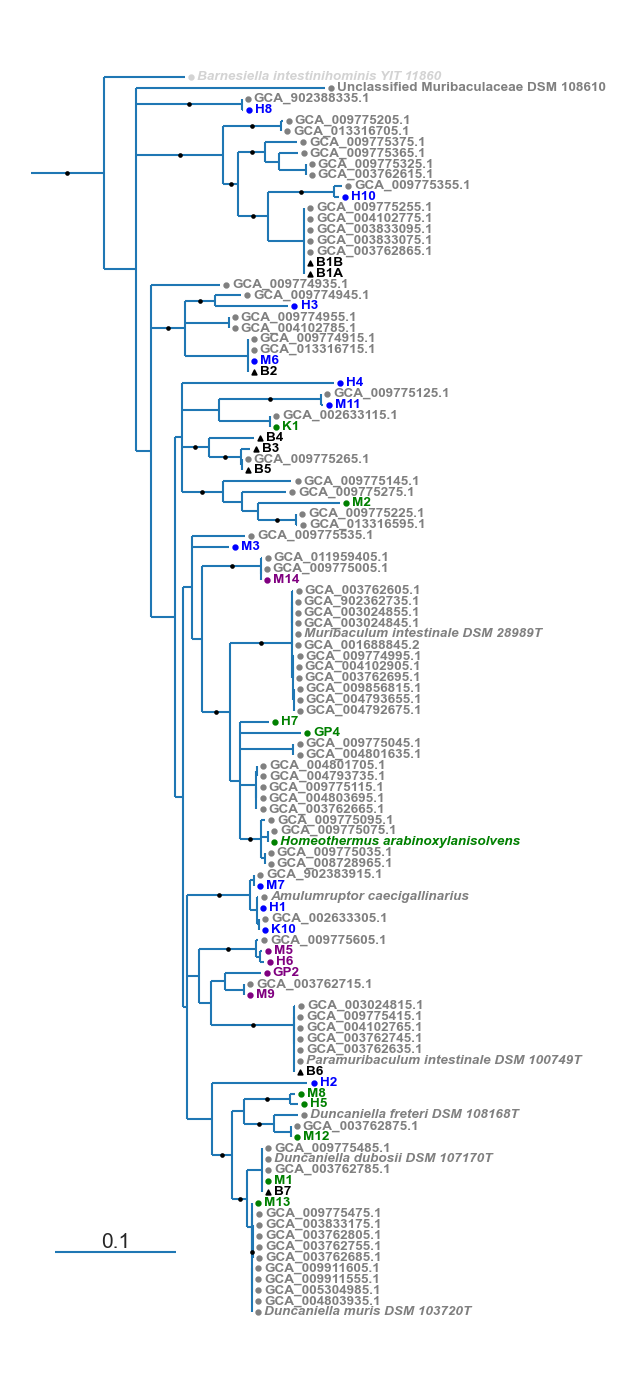

In [5]:
color_map = { 'starch': 'blue'
            , 'host': 'purple'
            , 'plant': 'green'
            }

italic_list = [ 'Barnesiella_viscericola_DSM_18177'
              , 'Barnesiella_intestinihominis_YIT_11860'
              , 'Bacteroides_ovatus_ATCC_8483'
              , 'Bacteroides_thetaiotaomicron_VPI5482'
              , 'Porphyromonas_gingivalis_ATCC_33277'
              , 'Homeothermus_arabinoxylanisolvens'
              , 'Muribaculum_intestinale_DSM_28989T'
              , 'Duncaniella_muris_DSM_103720T'
              , 'Duncaniella_freteri_DSM_108168T'
              , 'Duncaniella_dubosii_DSM_107170T'
              , 'Paramuribaculum_intestinale_DSM_100749T'
              , 'Amulumruptor_caecigallinarius'
              ]

con = sqlite3.connect('data/core.muri2.2.denorm.db')

mag = (
    pd.read_sql(
    """
SELECT *
FROM genome
JOIN checkm USING (genome_id)
JOIN genome_group USING (genome_id)
WHERE genome_group_id = 'muri2'
    """,
    index_col='genome_id',
    con=con,
    )
)

rename_taxon = {
#                  'Barnesiella_viscericola_DSM_18177': 'Bv'
#                , 'Bacteroides_ovatus_ATCC_8483': 'Bo'
#                , 'Bacteroides_thetaiotaomicron_VPI5482': 'Bt'
#                , 'Porphyromonas_gingivalis_ATCC_33277': 'Pg'
#                , 'Homeothermus_arabinoxylanisolvens': 'Ha'
#                , 'Muribaculum_intestinale_DSM_28989T': 'Mi'
#                , 'Duncaniella_muris_DSM_103720T': 'Dm'
#                , 'Duncaniella_freteri_DSM_108168T': 'Df'
#                , 'Duncaniella_dubosii_DSM_107170T': 'Dd'
#                , 'Paramuribaculum_intestinale_DSM_100749T': 'Pi'
#                , 'Amulumruptor_caecigallinarius': 'Ac'
#                , 'Barnesiella_intestinihominis_YIT_11860': 'Bi'
               }

for _name, x in mag.iterrows():
    if _name.startswith('GCA_'):
        rename_taxon[_name] = mag.loc[_name].genbank_accession
    else:
        rename_taxon[_name] = _name.replace('_', ' ')


colormap = color_map = { 'ormerod-starch': 'blue'
                       , 'ormerod-host': 'purple'
                       , 'ormerod-plant': 'green'
                       , 'public': 'grey'
                       , 'here': 'black'
                       , 'outgroup': 'lightgrey'
                       }

marker_map = {'ormerod-plant': 'o', 'ormerod-host': 'o', 'ormerod-starch': 'o', 'public': 'o', 'here': '^', 'outgroup': 'o'}

def _tax_plotter(clade, ax):
    if clade.name in rename_taxon:
        # Check if there's a renaming for a given clade.
        label = rename_taxon[clade.name]
    else:
        label = clade.name
        
#     if mag.subgroup[clade.name] == 'here':
#         label = label + '*'
        
    if clade.name in italic_list:
        textstyle = 'italic'
    else:
        textstyle = 'normal'
    
    color = colormap[mag.subgroup[clade.name]]
    ax.scatter(
        [clade.right + 0.005],
        [clade.y],
        color=color,
        marker=marker_map[mag.subgroup[clade.name]],
        s=5,
    )
    ax.annotate(label, xy=(clade.right + 0.01, clade.y),
                ha='left', va='center',
                weight='bold', style=textstyle,
                color=color, fontsize=6.5)
    
def _node_plotter(clade, ax):
    confidence = clade.confidence
    if confidence is None:
        return

    if confidence > 0.95:
        middle = (clade.right + clade.left) / 2
        if clade.is_terminal():
            hpos = middle  # clade.right - 0.013
        else:
            hpos = middle  # clade.right
        color = 'k'
        ax.scatter([hpos], [clade.y], color=color,
                   marker='o', s=5, linewidths=0, edgecolors='k', zorder=10)

    
    
tree = Phylo.read('data/core.a.mags.muri2.g.final.cds.TIGR02013-hits.sqz.gb.prot.nwk', 'newick')
# Rename taxa to species rather than gene.
for t in tree.get_terminals():
    t.name = t.name.rsplit('_', 1)[0]
    
outgroup = [
#               'Porphyromonas_gingivalis_ATCC_33277'
            'Bacteroides_ovatus_ATCC_8483'
            , 'Bacteroides_thetaiotaomicron_VPI5482'
           , 'Barnesiella_viscericola_DSM_18177'
           ]
view_outgroup = []

tree.root_with_outgroup(outgroup)
for t in outgroup:
    if t not in view_outgroup:
        tree.prune(t)
        
tree.clade.branch_length = 0.06
#tree.clade.confidence = None
tree.collapse_all(lambda c: c.confidence is not None and c.confidence < 0.7)
tree.ladderize(reverse=True)

fig, ax = plt.subplots(figsize=(3, 12))
tree_annotated = plot_tree(tree, ax,
                           tax_plotter=_tax_plotter,
                           node_plotter=_node_plotter)

#for confidence_label, color in [('> 95%', 'black'),
#                                ('> 90%', 'grey'),
#                                ('> 80%', 'lightgrey'),
#                                ('< 80%', 'white')
#                                ('> 80%', 'white')
#                               ]
#    ax.scatter([], [], color=color, label=confidence_label, s=50, linewidths=2, edgecolors='k')
ax.set_yticks([])
ax.set_xticks([])
#ax.legend(loc='upper left', title='confidence')

scale_xy = (0.02, 5.5)
scale_length = 0.1
_x, _y = scale_xy
ax.hlines([_y], [_x], [_x + scale_length], lw=1)
ax.annotate('{:.1}'.format(scale_length),
            xy=(_x + scale_length / 2, _y + 0.4),
            ha='center', fontsize=10)

# panel = 'A'
# ax.annotate(panel, xy=(0.02, 1.02), xycoords='axes fraction', fontsize=12)


ax.axis('off')
#fig.tight_layout()
 
plt.savefig('fig/phylogenetics_rpoB.pdf', dpi=250, bbox_inches='tight')